# Simulate a scan with GPcam on pre-measured data


In [1]:
from typing import *
from pathlib import Path
import time
from itertools import product
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tqdm.auto import tqdm

import dataloader as dl 

import smartscan as ss
from smartscan.utils import pretty_print_time
import smartscan.gp as ssgp



In [2]:
def reduce(spectrum) -> Tuple[float]:
    """Reduce a spectrum to its mean and std"""
    return 1-spectrum.mean(), 1-spectrum.std()

# load data

In [3]:
source_file =  Path(r"D:\data\SGM4 - 2022 - CrSBr\data\Kiss05_5.h5")
ldr = dl.formats.SGM4Loader(source_file)
ldr.load_stack(binning=5)
xdata = ldr.to_xarray()
del ldr
xdata


Loading Data:   0%|          | 0/1680 [00:00<?, ?it/s]

<xarray.DataArray (FSamX: 35, FSamY: 48, Kinetic Energy: 100, OrdinateRange: 100)>
array([[[[6.16244888e+00, 1.00052242e+01, 1.68643742e+01, ...,
          4.85277206e-01, 0.00000000e+00, 0.00000000e+00],
         [1.40908976e+01, 1.89462738e+01, 1.50903416e+01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.51476498e+01, 1.56562681e+01, 1.49155140e+01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 9.82466757e-01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[1.52864542e+01, 1.29107094e+01, 9.88801384e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.16797504e+01, 1.14652815e+01, 1.06108780e+01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.26572180e+01, 1.31007071e+01, 1.60870934e+01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
          0.00000000e+00, 1.07595265e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[1.85625896e+01, 9.91199780e+00, 1.13710594e+01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.43047562e+01, 1.49611406e+01, 1.06171675e+01, ...,
          0.00000000e+00, 1.00353575e+00, 0.00000000e+00],
         [1.47609730e+01, 2.17069359e+01, 1.09395676e+01, ...,
          1.29917693e+00, 7.78674245e-01, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]],
      dtype=float32)
Coordinates:
  * FSamY           (FSamY) float64 -900.0 -915.0 ... -1.59e+03 -1.605e+03
  * FSamX           (FSamX) float64 -1.9e+03 -1.915e+03 ... -2.395e+03 -2.41e+03
  * Kinetic Energy  (Kinetic Energy) float64 70.0 70.05 70.1 ... 74.94 74.99
  * OrdinateRange   (OrdinateRange) float64 -15.0 -14.7 -14.4 ... 14.64 14.94
Attributes: (12/36)
    Detector/AnaAzi:                  [89.9909991 89.9909991 89.9909991 ... 8...
    Detector/AnaPolar:                [-13.999265 -13.999265 -13.999265 ... -...
    Detector/Kinetic Start Energy:    70.0
    Detector/Kinetic End Energy:      75.0
    Detector/Samples:                 1.0
    Detector/Step Width:              0.0100200401
    ...                               ...
    Monochromator/Beam Current:       [180.15434294 180.10668645 180.05353114...
    Monochromator/Exit Slit:          [3831.5486654 3831.5486654 3831.5486654...
    Monochromator/Grating:            [b'MEG' b'MEG' b'MEG' ... b'MEG' b'MEG'...
    Monochromator/Mono Energy:        [73.99997226 73.99997226 73.99997226 .....
    Monochromator/Photon Energy:      [73.99997226 73.99997226 73.99997226 .....
    Monochromator/Undulator Gap:      [31.625 31.625 31.625 ... 31.625 31.625...

## data as stack of spectra and point coordinates

In [4]:
map_shape = xdata.shape[:2]
all_positions = np.array(tuple(product(range(xdata.shape[0]),range(xdata.shape[1]))))
all_spectra = xdata.values.reshape(-1, *xdata.shape[-2:])
scan_limits = np.array([all_positions.min(axis=0),all_positions.max(axis=0)]).T
all_reduced = np.stack([reduce(s) for s in all_spectra],axis=-1)
reduced_maps = all_reduced.reshape(2,*map_shape)

number of positions: 1680
number of features: 2
map shape: (35, 48)
scan limits: [ 0 34  0 47]
feature 0:  min=-6.852 | max=0.856 | mean=-4.721 | std=1.441
feature 1:  min=-7.668 | max=0.603 | mean=-5.258 | std=1.498


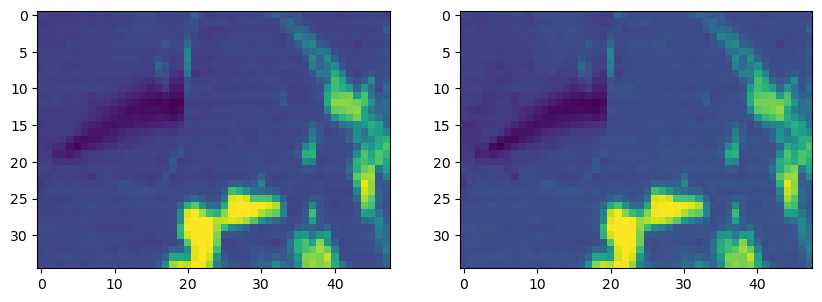

In [5]:
print(f"number of positions: {len(all_positions)}")
print(f"number of features: {len(all_reduced)}")
print(f"map shape: {map_shape}")
print(f"scan limits: {scan_limits.ravel()}")
for i in range(len(all_reduced)):
    print(f"feature {i}: ",
          f"min={reduced_maps[i].min():.3f} |",
          f"max={reduced_maps[i].max():.3f} |",
          f"mean={reduced_maps[i].mean():.3f} |",
          f"std={reduced_maps[i].std():.3f}",
    )
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(reduced_maps[0])
ax[1].imshow(reduced_maps[1]);

# define a measurement function

In [6]:
def measure(pos: Sequence[float]) -> Tuple[float]:
    """Measure a spectrum at a given position"""
    x,y = pos
    return np.array(reduced_maps[:,x,y])[None,:]

# GPcam

In [7]:
reload(ssgp)

<module 'smartscan.gp' from 'C:\\Users\\stein\\OneDrive\\Documents\\_Work\\_code\\ARPES-ASTRID\\smartscan\\smartscan\\gp\\__init__.py'>

## define parameters

In [8]:
optimizer_pars = {
    'input_space_dimension': 2,
    'output_space_dimension': 1,
    'output_number': 2,
    'input_space_bounds': scan_limits,
}
hyperparameter_bounds = np.array(
    [[0.001,1e9],[1,1000],[1,1000],[1,1000],[1,1000]]
)
init_hyperparameters = np.array(
        [4.71907062e+06, 4.07439017e+02, 3.59068120e+02,4e2,4e2]
)
train_pars = {
    'hyperparameter_bounds': hyperparameter_bounds,
    'pop_size': 20,
    'tolerance': 1e-6,
    'max_iter': 2,
}
fvgp_pars = {
    'init_hyperparameters' : init_hyperparameters,
    'compute_device': 'cpu',
    'gp_kernel_function': None,
    'gp_mean_function': None,
    'use_inv':False,
    'ram_economy': True,
}
ask_pars = {
    'n': 1, 
    'acquisition_function': ssgp.ndim_aqfunc, 
    'bounds': None,
    'method': 'global', 
    'pop_size': 20, 
    'max_iter': 10, 
    'tol': 10e-6, 
    'x0': None, 
    'dask_client': None,
}
cost_func_params = {
    'speed':300,
    'dwell_time':1.0,
    'dead_time':0.6,
    'point_to_um':15,
    'weight':1.0,
    'min_distance':1.6
}

# Single point initializationm

In [9]:
init_positions = np.array([
    [map_shape[0]//2,map_shape[1]//2],
    # [map_shape[0]//2,map_shape[1]//2],
])
init_values = np.array([
    np.array(reduce(xdata[init_positions[:,0],init_positions[:,1]].values)),
    # np.array(reduce(xdata[init_positions[0],init_positions[1]].values)),
])
init_positions, init_values


(array([[17, 24]]), array([[-5.19724798, -5.70427227]]))

In [10]:
gp = ssgp.fvGPOptimizer(**optimizer_pars)
gp.tell(init_positions,init_values)#,value_positions=[[[0],[1]],[[0],[1]]])
gp.init_fvgp(**fvgp_pars)
gp.train_gp(**train_pars)
positions = init_positions.copy()
values = init_values.copy()
cost_func_params.update({
    'prev_points':gp.x_data,
    'weight':0.1,
    'min_distance':.6,
})
gp.init_cost(ssgp.compute_costs,cost_func_params)
positions.shape, values.shape


((1, 2), (1, 2))

In [11]:
pos, vals = ssgp.measurement_loop(
    init_positions, 
    init_values, 
    gp,
    measure_func = measure,
    n_points=500, 
    train_every=100000,
    train_at = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5120],
    verbose=True,
)

Acquisition loop:   0%|          | 0/500 [00:00<?, ?it/s]

positions: [[17 24]]
values: [[-5.19724798 -5.70427227]]


c:\Users\stein\anaconda3\envs\smartscan\lib\site-packages\scipy\optimize\_differentialevolution.py:377: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Exception: ('x request in evaluate_gp_acquisition_function has wrong dimensionality.', (40, 2))

In [ ]:
gp.input_dim

3

In [ ]:
print(f'Number of repeated points: {how_many_repeated_points(pos)}')
print(f'repeated points: {duplicate_positions(pos)}')
# print(f'scan time: {scan_time(pos_wcost,cost_func_params):.2f} s')

Number of repeated points: 0
repeated points: {}


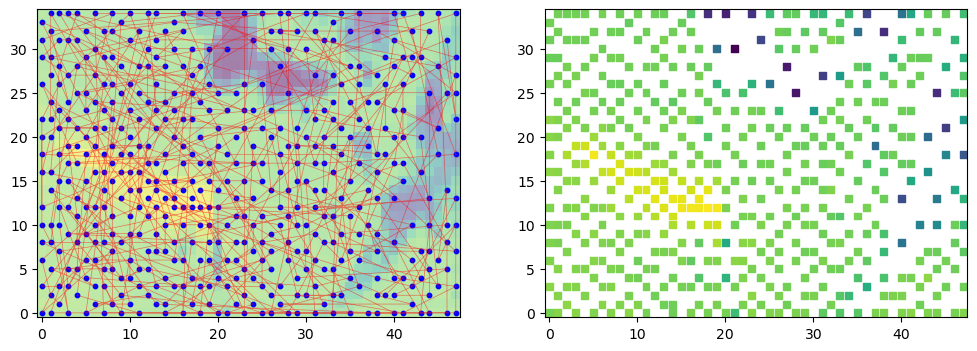

In [ ]:
n = 500
p,v = pos[:n], vals[:n]
how_many_repetitions(p)
# vis_map_with_path(p,v,reduced_maps=reduced_maps)
plot_map_with_path_and_scatterplot(p,v,reduced_maps=reduced_maps)

In [ ]:
print(f'scan time: {scan_time(pos,cost_func_params):.2f} s')

scan time: 1000827.71 s


In [ ]:
# count repeated points
from collections import Counter
counts = list(dict(Counter(tuple(map(tuple,pos_wcost)))).values())

print(f'Number of repeated points: {sum(counts)-len(counts)}')


In [ ]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

vis_map_with_path(pos_wcost, values_wcost,reduced_maps=reduced_maps,ax=axes[0])
vis_map_with_path(pos_nocost, values_nocost,reduced_maps=reduced_maps,ax=axes[1])

# now for something silly!

In [ ]:
gp = fvGPOptimizer(**optimizer_pars)
gp.tell(init_positions,init_values)
gp.init_fvgp(**fvgp_pars)
gp.train_gp(**train_pars)
positions = init_positions.copy()
values = init_values.copy()
positions.shape, values.shape
cfp = cost_func_params.copy()
cfp['weight'] = 0.1
gp.init_cost(cost_function,cost_func_params)

In [ ]:

pos_highcost, values_highcost = measurement_loop(
    init_positions, 
    init_values, 
    n_points=500, 
    train_every=50,
    train_at = [10, 20],
    verbose=True,
)
counts = list(dict(Counter(tuple(map(tuple,pos_highcost)))).values())
print(f'Number of repeated points: {sum(counts)-len(counts)}')

In [ ]:
vis_map_with_path(pos_highcost, values_highcost,reduced_maps=reduced_maps)

In [ ]:
plt.figure()
n = 500
plt.scatter(pos_highcost[:n,1],pos_highcost[:n,0],c=values_highcost[:n,0],cmap='viridis')

In [ ]:
print(f'scan time: {scan_time(pos_highcost,cost_func_params):.2f} s')

In [ ]:
print(f'no cost scan time:   ' +pretty_print_time(scan_time(pos_nocost,cost_func_params)))
print(f'low cost scan time:  ' +pretty_print_time(scan_time(pos_wcost,cost_func_params)))
print(f'high cost scan time: ' +pretty_print_time(scan_time(pos_highcost,cost_func_params)))
print(f'raster scan time:    ' +pretty_print_time(scan_time(all_positions,cost_func_params)))


In [ ]:
def pretty_print_time(t):
    """Print time as hh:mm:ss"""
    h = int(t//3600)
    m = int((t%3600)//60)
    s = int(t%60)
    return f'{h:02d}:{m:02d}:{s:02d}'

In [ ]:
all_positions

In [ ]:
def get_raw_data(positions,all_positions,xdata):
    raw = []
    for n in range(len(all_positions)):
        if all_positions[n] in positions:
            i,j = all_positions[n]
            raw.append(xdata[i,j,...].values)
    return raw

    

In [ ]:
raw_nocost = get_raw_data(pos_nocost,all_positions,xdata)

In [ ]:
raw_nocost[0].shape


# kmeans on this thing

In [ ]:
import sklearn.cluster as cluster  


In [ ]:
res = cluster.kmeans(raw_nocost,n_clusters=3)